# Combining it all

Here we will combine the approaches of all the past inversions. Here our the main steps we will follow:

1) create a true topography and synthetic observed gravity
2) create a starting model from the points of known topography (`constraints`) 
3) calculate a starting misfit
4) perform a damping parameter cross validation to determine the optimal damping value
5) use this damping value to perform a cross validation to find the optimal density and reference level values
6) create the weighting grid to help the inversion adhere to the constraints
7) perform a full final inversion constrained by the `weighting grid`, using the optimal damping, density, and reference level values. 


## Import packages

In [14]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import pandas as pd
import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils

from invert4geom import (
    cross_validation,
    inversion,
    plotting,
    regional,
    synthetic,
    utils,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1) Create synthetic topography and observed gravity data

### True topography

In [15]:
# set grid parameters
spacing = 1000
region = [0, 40000, 0, 30000]

# create synthetic topography data
true_topography = synthetic.synthetic_topography_simple(
    spacing,
    region,
)

## 2) Create starting topography from constraints

Sample the starting topography at 10 random locations and regrid with those sampled values. This sumulates only knowing the depth to this topography at 10 boreholes.

In [16]:
# create 10 random point withing the region
num_constraints = 10
coords = vd.scatter_points(region=region, size=num_constraints, random_state=7)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points, true_topography, "upward", coord_names=("easting", "northing")
)

# grid the sampled values using verde
starting_topography = utils.create_topography(
    method="splines",
    region=region,
    spacing=spacing,
    constraints_df=constraint_points,
    dampings=np.logspace(-10, 0, 100),
)

# re-sample the starting topography at the constraint points to see how the gridded did
constraint_points = utils.sample_grids(
    constraint_points,
    starting_topography,
    "starting_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.starting_topography)
print(f"RMSE at the constraints between the starting and true topography: {rmse:.2f} m")

constraint_points

RMSE at the constraints between the starting and true topography: 19.26 m


,easting,northing,upward,starting_topography
0,3052.331575,20376.899884,619.779099,580.163740
1,31196.751690,24112.171083,479.563412,481.652035
2,17536.369258,11428.233994,465.786893,458.230368
3,28938.607113,1978.090407,426.413502,438.512760
4,39119.580480,8644.367979,428.773305,425.210470
5,21539.834816,27287.805832,546.901160,547.287244
6,20044.818546,6401.560607,450.406755,455.069067
7,2882.045334,13563.718855,460.979806,499.138482
8,10737.559204,27936.180591,614.084318,624.948915
9,19995.300033,746.976827,470.409607,452.397262


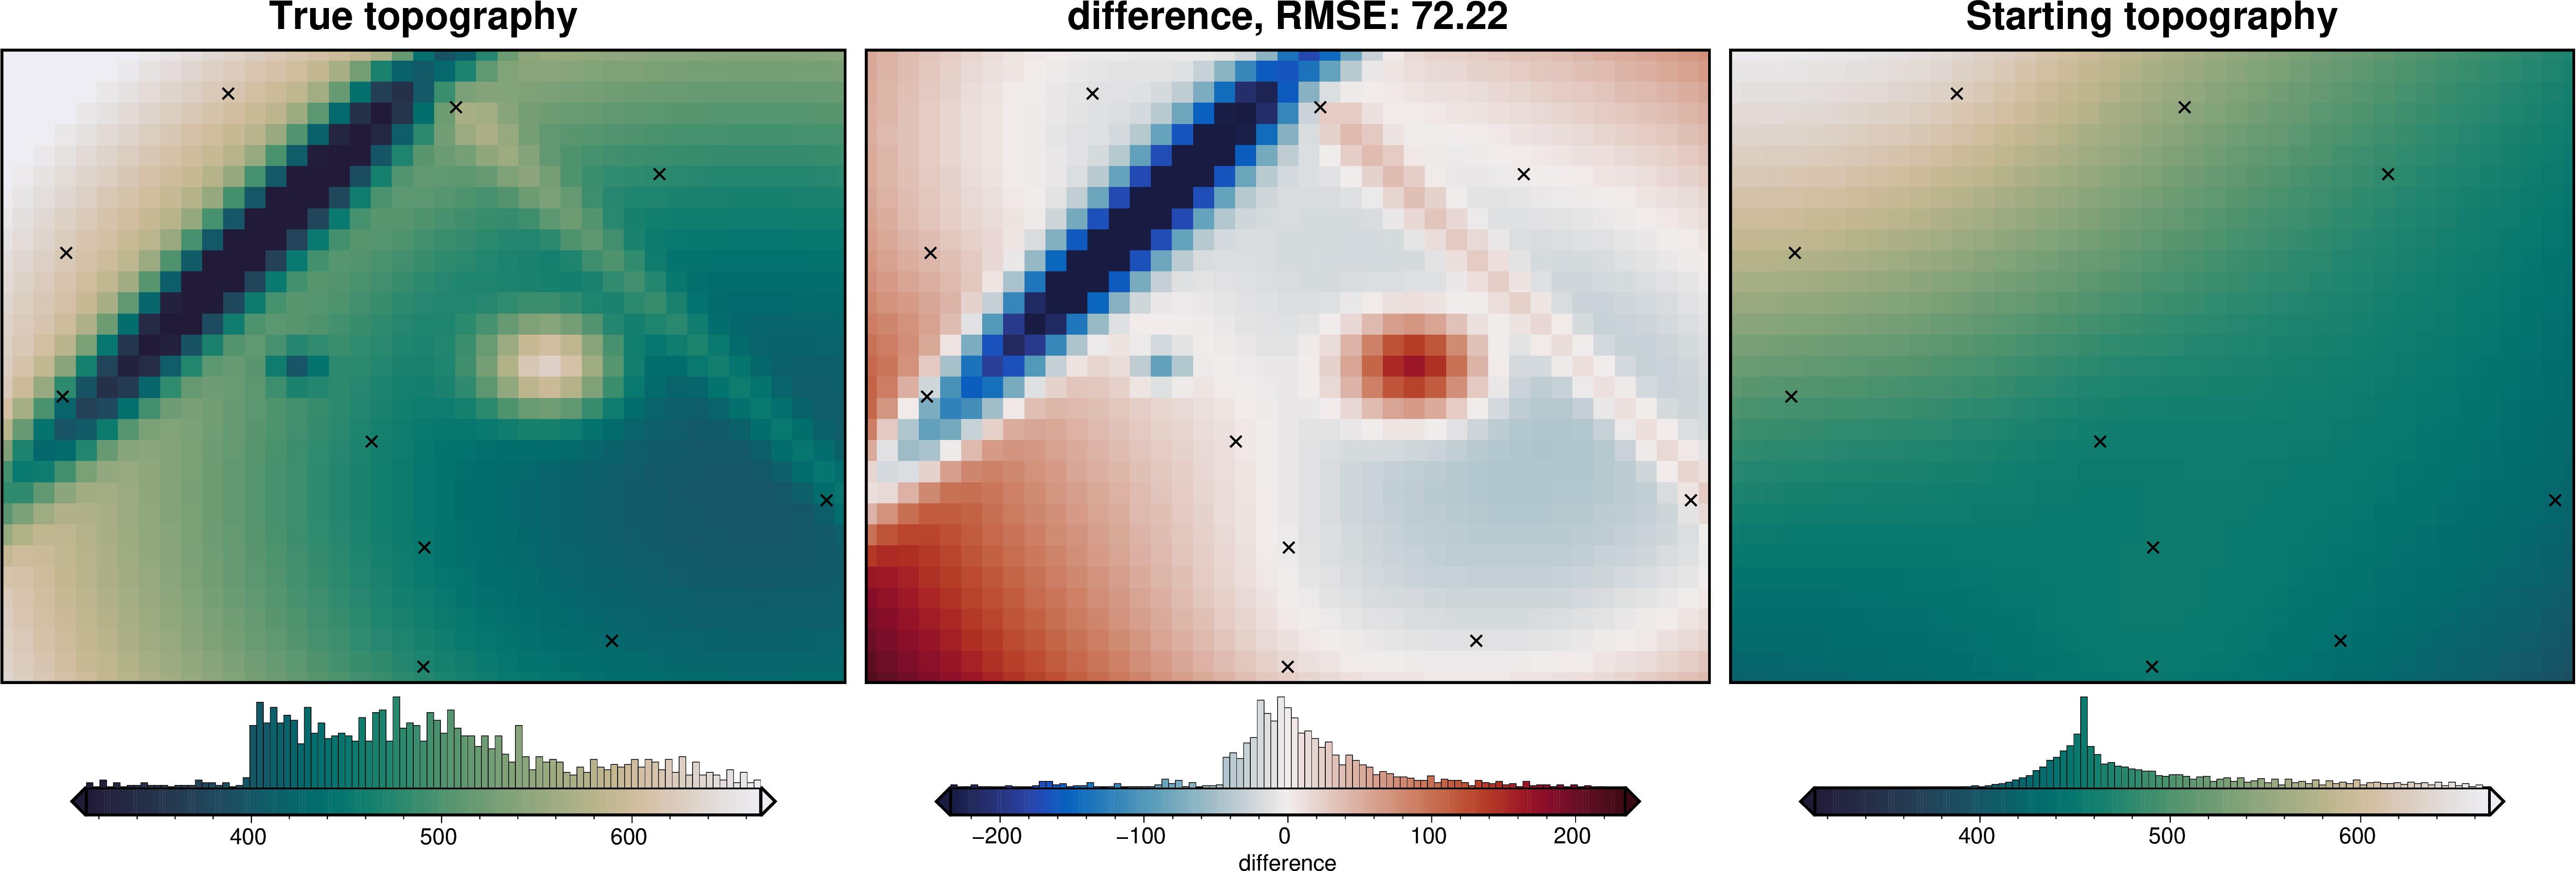

In [17]:
_ = polar_utils.grd_compare(
    true_topography,
    starting_topography,
    # plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

### Prism layer

In [18]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
true_density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
true_zref = true_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    true_topography >= true_zref, true_density_contrast, -true_density_contrast
)

# create layer of prisms
prisms = utils.grids_to_prisms(
    true_topography,
    true_zref,
    density=density_grid,
)

### Forward gravity of true prism layer

In [26]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["grav"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df

  0%|          | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,grav
0,0.0,0.0,1000.0,9.534643
1,0.0,1000.0,1000.0,10.422834
2,0.0,2000.0,1000.0,9.949973
3,0.0,3000.0,1000.0,9.269279
4,0.0,4000.0,1000.0,8.532160
...,...,...,...,...
1266,30000.0,36000.0,1000.0,3.332716
1267,30000.0,37000.0,1000.0,3.330307
1268,30000.0,38000.0,1000.0,3.335438
1269,30000.0,39000.0,1000.0,3.300721


INFO:root:Standard deviation used for noise: [0.5]


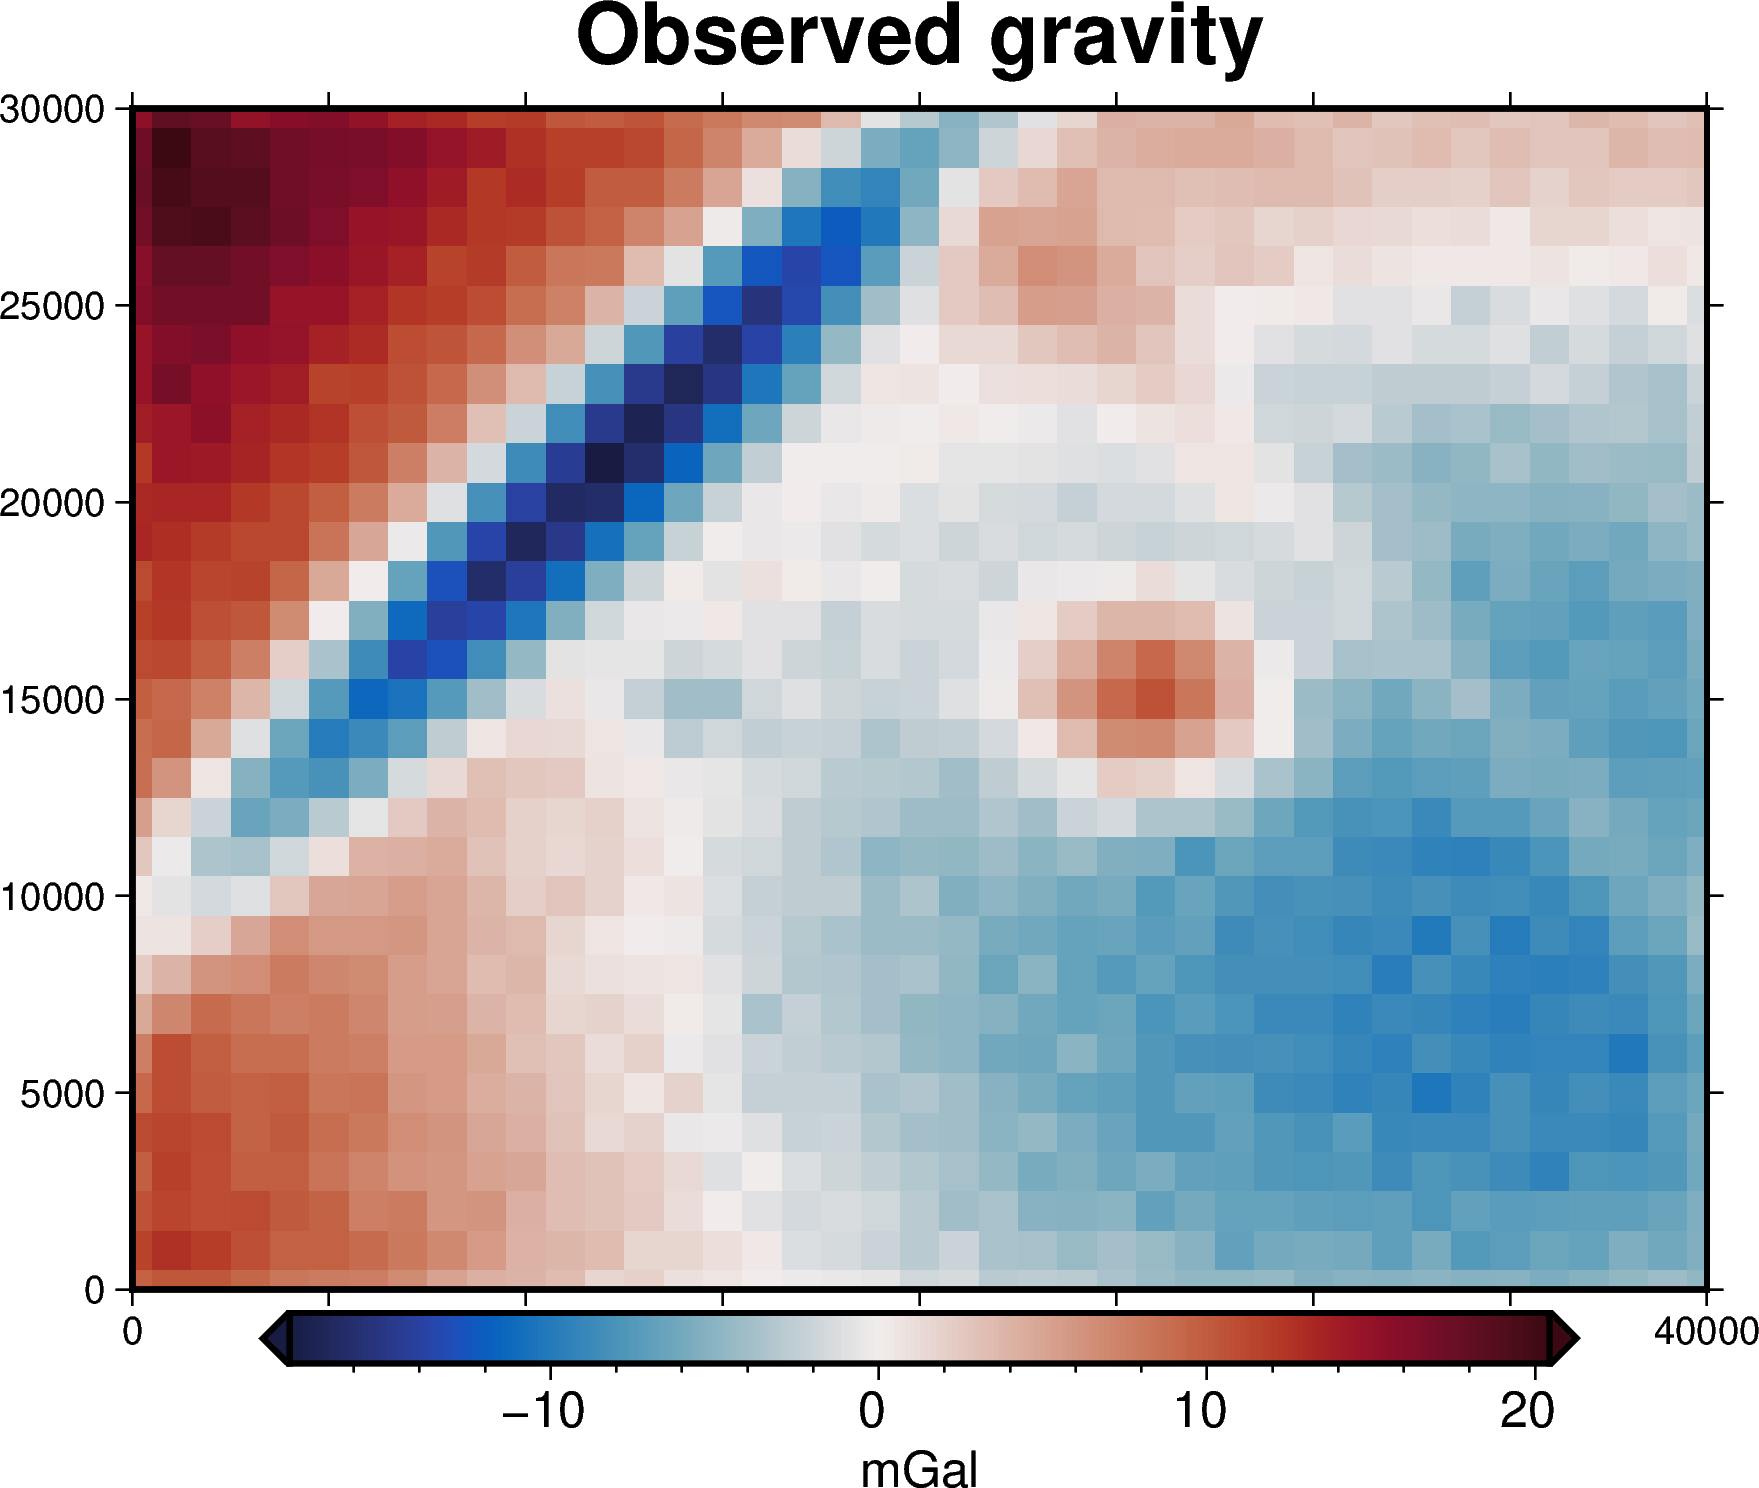

In [27]:
# contaminate gravity with 0.5 mGal of random noise
grav_df["observed_grav"], stddev = synthetic.contaminate(
    grav_df.grav,
    stddev=0.5,
    percent=False,
    seed=0,
)

# plot the observed gravity
fig = maps.plot_grd(
    grav_df.set_index(["northing", "easting"]).to_xarray().observed_grav,
    fig_height=10,
    title="Observed gravity",
    cmap="balance+h0",
    grd2_cpt=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)
fig.show()

In [28]:
# resample to half spacing
grav_df = cross_validation.resample_with_test_points(spacing, grav_df, region)
grav_df

,northing,easting,test,upward,grav,observed_grav
0,0.0,0.0,False,1000.0,9.534643,9.617711
1,0.0,500.0,True,1000.0,10.063805,10.050215
2,0.0,1000.0,False,1000.0,10.422834,10.376985
3,0.0,1500.0,True,1000.0,10.284459,10.440419
4,0.0,2000.0,False,1000.0,9.949973,10.290387
...,...,...,...,...,...,...
4936,30000.0,38000.0,False,1000.0,3.335438,3.501867
4937,30000.0,38500.0,True,1000.0,3.346051,3.145170
4938,30000.0,39000.0,False,1000.0,3.300721,2.848068
4939,30000.0,39500.0,True,1000.0,3.104991,2.936345


## 3) Calculate starting gravity misfit 
Now we need to calculate the forward gravity of the starting topography. We then can subtract it from our observed gravity to get a starting gravity misfit.

We don't know the optimal values for the density contrast or the reference level, so we will make a guess at appropiate values for the starting model.

In [29]:
# the true zref value is 492 m
zref = 300

# the true density contrast is 2669 kg/m3
density_contrast = 2300

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    starting_topography >= zref, density_contrast, -density_contrast
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density_grid,
)

# calculate forward gravity of starting prism layer
grav_df["starting_grav"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# calculate misfit as observed - starting
grav_df["misfit"] = grav_df["observed_grav"] - grav_df["starting_grav"]

# estimate regional with the median misfit at constraints
grav_df = regional.regional_separation(
    method="dc_shift",
    grav_df=grav_df,
    grav_data_column="misfit",
    regional_column="reg",
    constraints_df=constraint_points,
)

# remove the regional from the misfit to get the residual
grav_df["res"] = grav_df.misfit - grav_df.reg

grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

,northing,easting,test,upward,grav,observed_grav,starting_grav,misfit,reg,res
0,0.0,0.0,False,1000.0,9.534643,9.617711,6.151693,3.466018,-18.017054,21.483072
1,0.0,500.0,True,1000.0,10.063805,10.050215,7.091805,2.958410,-18.017054,20.975464
2,0.0,1000.0,False,1000.0,10.422834,10.376985,7.536995,2.839989,-18.017054,20.857043
3,0.0,1500.0,True,1000.0,10.284459,10.440419,7.791025,2.649394,-18.017054,20.666448
4,0.0,2000.0,False,1000.0,9.949973,10.290387,7.959613,2.330774,-18.017054,20.347828
...,...,...,...,...,...,...,...,...,...,...
4936,30000.0,38000.0,False,1000.0,3.335438,3.501867,11.472986,-7.971120,-18.017054,10.045934
4937,30000.0,38500.0,True,1000.0,3.346051,3.145170,11.150991,-8.005821,-18.017054,10.011233
4938,30000.0,39000.0,False,1000.0,3.300721,2.848068,10.716399,-7.868331,-18.017054,10.148723
4939,30000.0,39500.0,True,1000.0,3.104991,2.936345,10.025897,-7.089552,-18.017054,10.927502


/home/mdtanker/polartoolkit/src/polartoolkit/maps.py:883: UserWarning: getting max/min values from grid, if cpt_lims were used to create the colorscale, histogram will not properly align with colorbar!
  add_colorbar(
/home/mdtanker/polartoolkit/src/polartoolkit/maps.py:883: UserWarning: getting max/min values from grid, if cpt_lims were used to create the colorscale, histogram will not properly align with colorbar!
  add_colorbar(
makecpt [ERROR]: Option T: min >= max


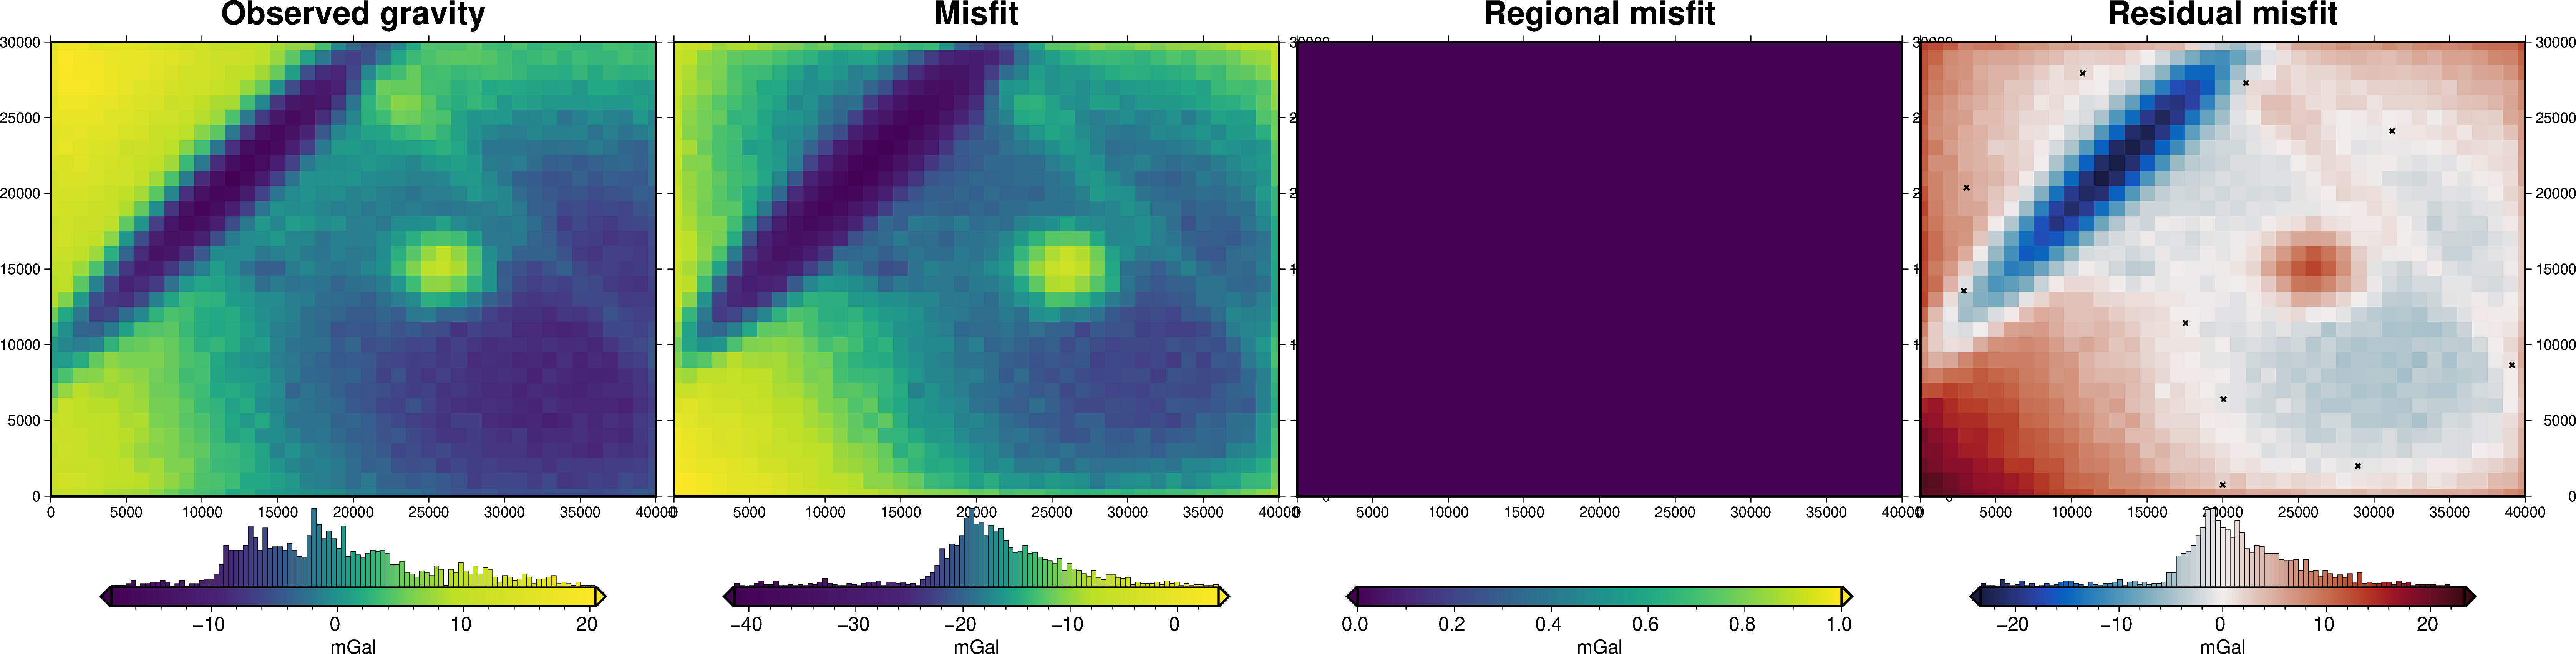

In [30]:
grav_grid = grav_df[~grav_df.test].set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.observed_grav,
    fig_height=10,
    title="Observed gravity",
    cmap="viridis",
    hist=True,
    grd2cpt=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.misfit,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Misfit",
    cmap="viridis",
    hist=True,
    grd2cpt=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.reg,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Regional misfit",
    cmap="viridis",
    hist=True,
    # grd2cpt=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.res,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    cpt_lims=[-vd.maxabs(grav_grid.res), vd.maxabs(grav_grid.res)],
    # cpt_lims=[-50, 50],
    hist=True,
    grd2cpt=False,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.15c",
)
fig.show()

## 4) Damping parameter cross validation

In [31]:
# set Python's logging level
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# set kwargs to pass to the inversion
kwargs = {
    "grav_data_column": "observed_grav",
    "prism_layer": starting_prisms,
    "deriv_type": "annulus",
    # set stopping criteria
    "max_iterations": 200,
    "l2_norm_tolerance": 0.5,
    "delta_l2_norm_tolerance": 1.005,
}

# set which damping parameters to include
dampings = np.logspace(-3, 0, 8)

best_inv_results, best_damping, _, _, scores = cross_validation.grav_optimal_parameter(
    training_data=grav_df[grav_df.test == False],  # noqa: E712
    testing_data=grav_df[grav_df.test == True],  # noqa: E712
    param_to_test=("solver_damping", dampings),
    progressbar=True,
    # plot_grids=True,
    plot_cv=False,
    verbose=True,
    **kwargs,
)

solver_damping values:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

INFO:root:solver_damping value: 0.001 -> Score: 3.8263142309967244
INFO:root:solver_damping value: 0.0026826957952797246 -> Score: 2.7385040858169734
INFO:root:solver_damping value: 0.0071968567300115215 -> Score: 1.3041276685681624
INFO:root:solver_damping value: 0.019306977288832496 -> Score: 0.24221088306919816
INFO:root:solver_damping value: 0.0517947467923121 -> Score: 0.3025686318514326
INFO:root:solver_damping value: 0.13894954943731375 -> Score: 0.3016794990228103
INFO:root:solver_damping value: 0.3727593720314938 -> Score: 0.56529459550981
INFO:root:solver_damping value: 1.0 -> Score: 6.653485066802009
INFO:root:Best score of 0.24221088306919816 with solver_damping=0.019306977288832496


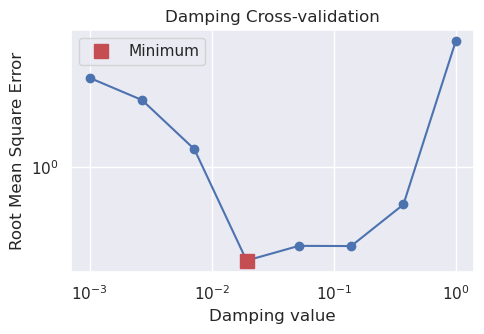

In [32]:
# Compare the scores and the damping values
plotting.plot_cv_scores(
    scores,
    dampings,
    param_name="Damping",
    logx=True,
    logy=True,
)

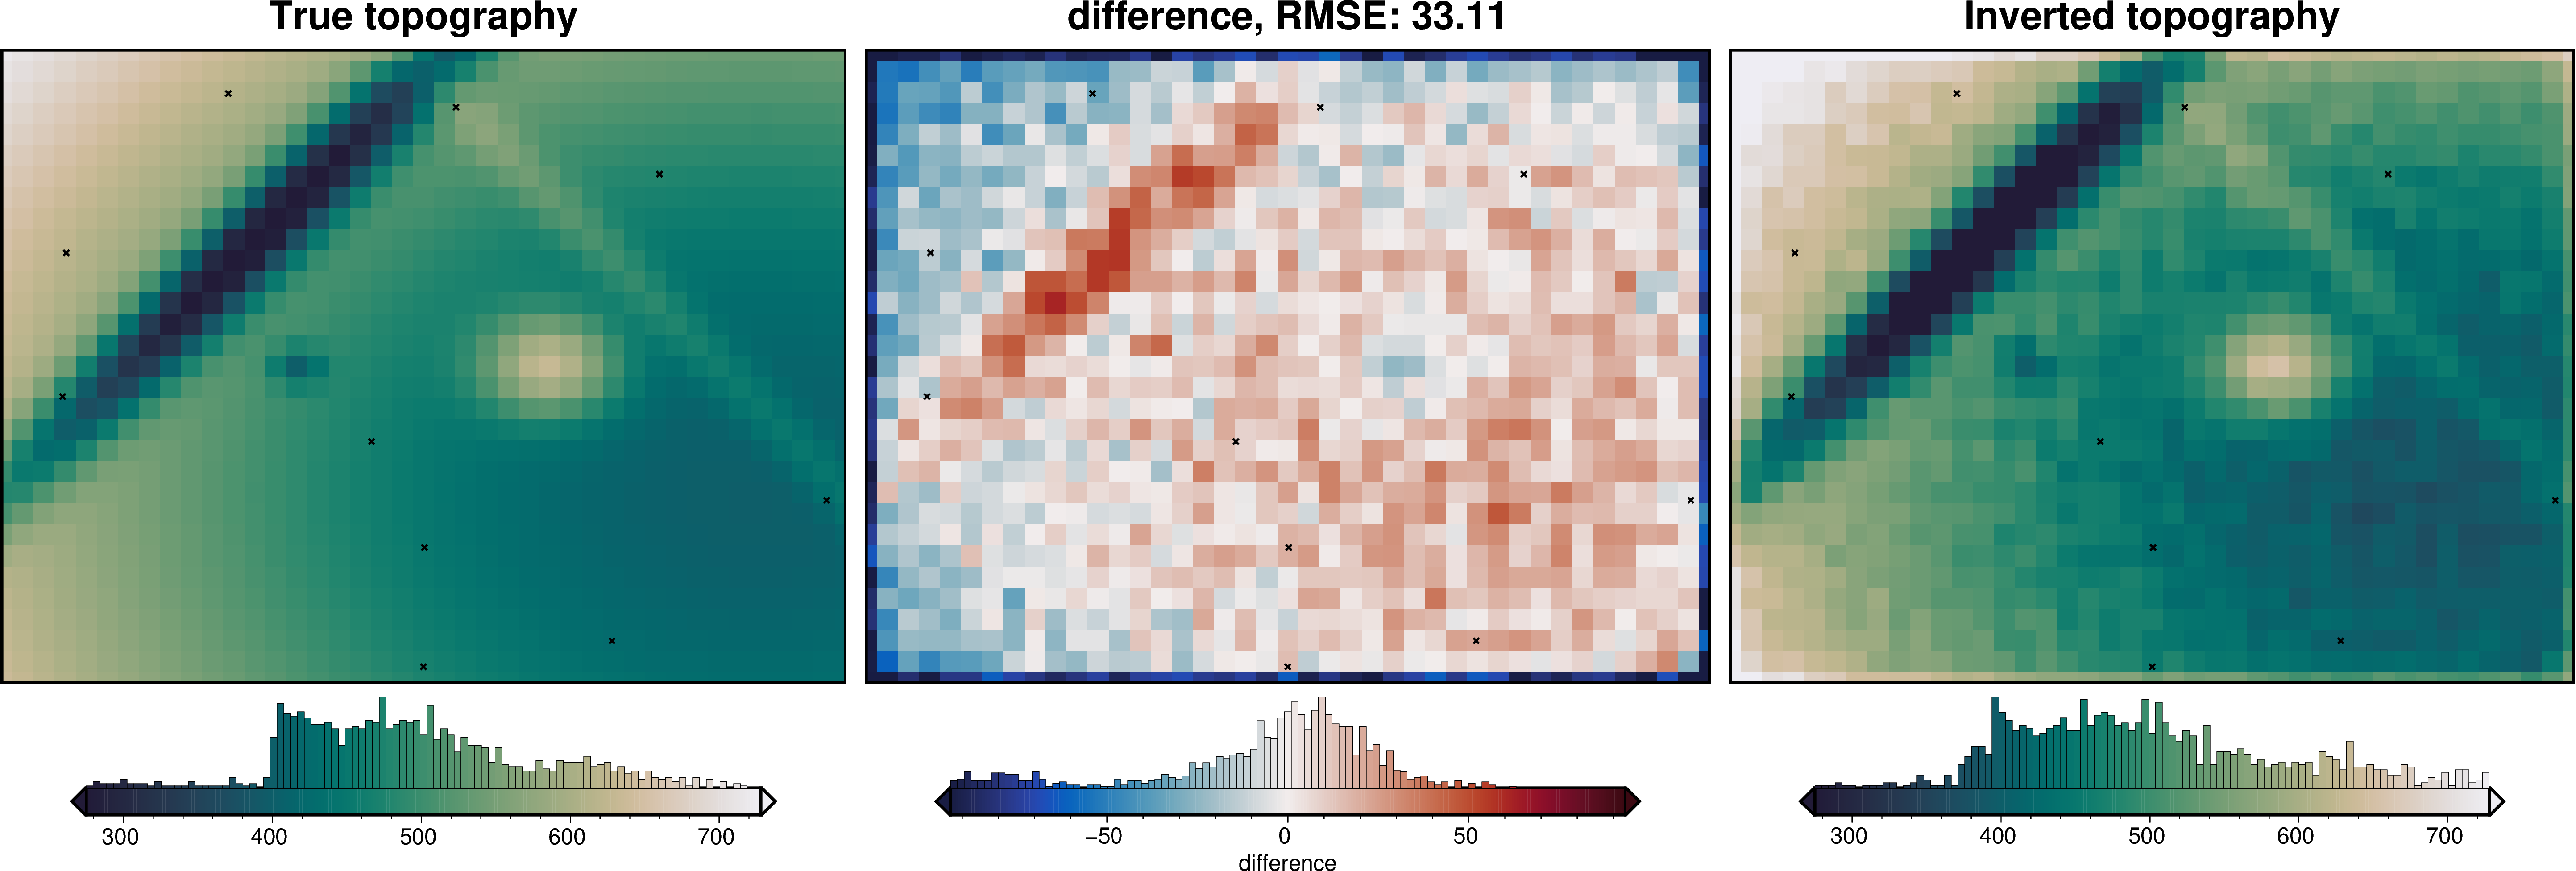

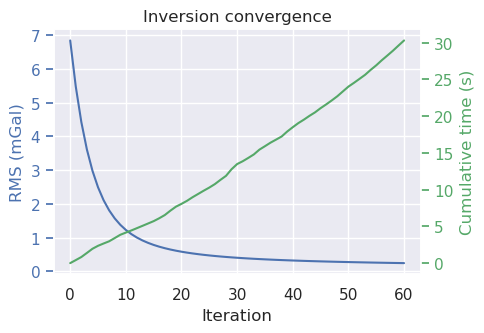

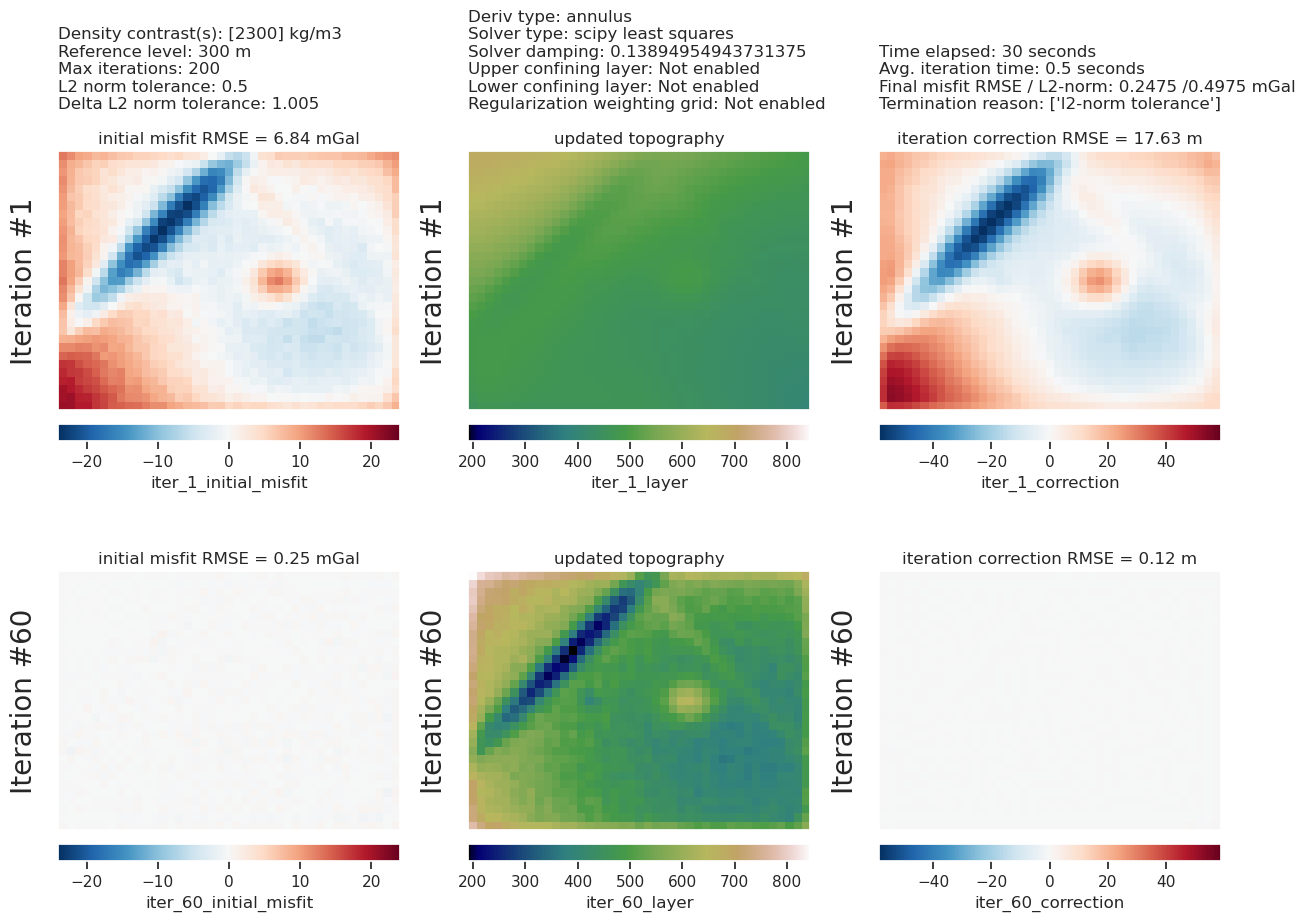

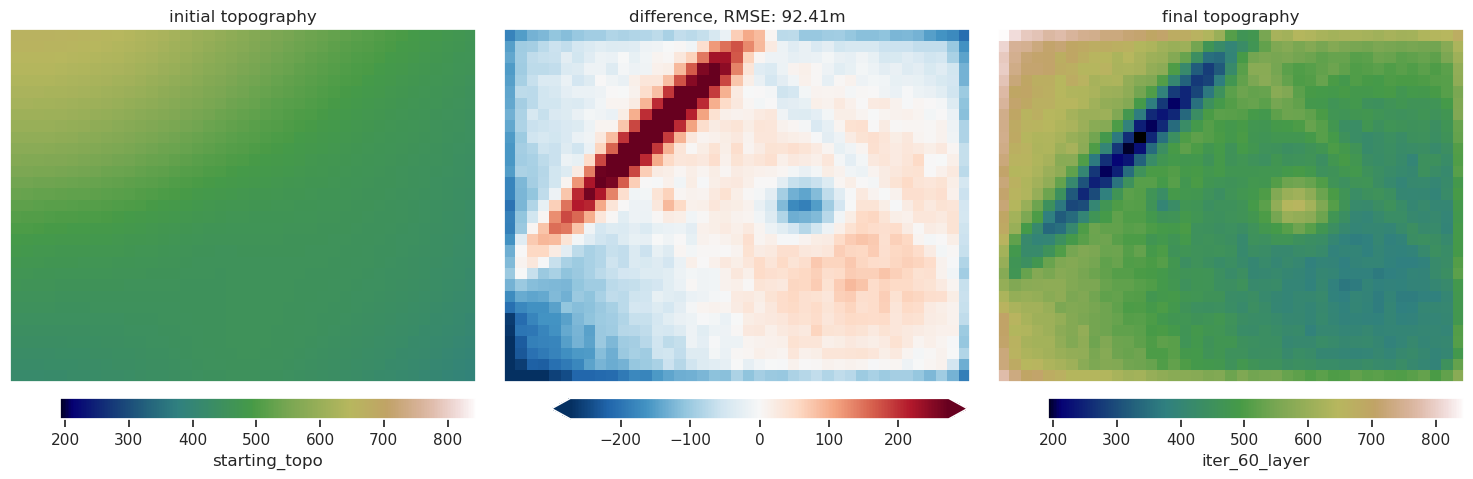

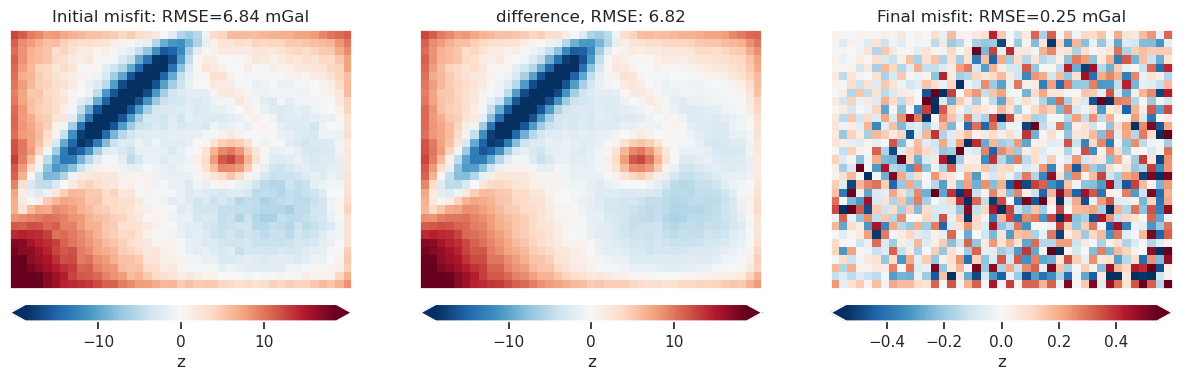

In [15]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = best_inv_results

plotting.plot_convergence(
    grav_results,
    iter_times=parameters["Iteration times"],
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.15c",
)

## 5) Cross validation for density and reference level

We will use the optimal damping value found in the previous step.

In [33]:
# we don't need the testing points anymore
grav_df = grav_df[grav_df.test == False].copy()  # noqa: E712
grav_df = grav_df.drop(columns=["test"])
grav_df

,northing,easting,upward,grav,observed_grav,starting_grav,misfit,reg,res
0,0.0,0.0,1000.0,9.534643,9.617711,6.151693,3.466018,-18.017054,21.483072
2,0.0,1000.0,1000.0,10.422834,10.376985,7.536995,2.839989,-18.017054,20.857043
4,0.0,2000.0,1000.0,9.949973,10.290387,7.959613,2.330774,-18.017054,20.347828
6,0.0,3000.0,1000.0,9.269279,9.341932,8.185137,1.156795,-18.017054,19.173849
8,0.0,4000.0,1000.0,8.532160,8.284528,8.346950,-0.062422,-18.017054,17.954632
...,...,...,...,...,...,...,...,...,...
4932,30000.0,36000.0,1000.0,3.332716,2.794223,12.378844,-9.584621,-18.017054,8.432433
4934,30000.0,37000.0,1000.0,3.330307,3.683446,11.969173,-8.285727,-18.017054,9.731327
4936,30000.0,38000.0,1000.0,3.335438,3.501867,11.472986,-7.971120,-18.017054,10.045934
4938,30000.0,39000.0,1000.0,3.300721,2.848068,10.716399,-7.868331,-18.017054,10.148723


Zref/Density pairs:   0%|          | 0/36 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

INFO:root:Reference level: 400.0, Density contrast: 2400.0 -> Score: 15.59812947104699
INFO:root:Reference level: 400.0, Density contrast: 2520.0 -> Score: 12.429754799102533
INFO:root:Reference level: 400.0, Density contrast: 2640.0 -> Score: 10.408533116946813
INFO:root:Reference level: 400.0, Density contrast: 2760.0 -> Score: 8.571528229750461
INFO:root:Reference level: 400.0, Density contrast: 2880.0 -> Score: 7.695187157192891
INFO:root:Reference level: 400.0, Density contrast: 3000.0 -> Score: 8.068326641523406
INFO:root:Reference level: 440.0, Density contrast: 2400.0 -> Score: 15.747604247677335
INFO:root:Reference level: 440.0, Density contrast: 2520.0 -> Score: 12.410725595731606
INFO:root:Reference level: 440.0, Density contrast: 2640.0 -> Score: 10.307434874464763
INFO:root:Reference level: 440.0, Density contrast: 2760.0 -> Score: 8.351788998180615
INFO:root:Reference level: 440.0, Density contrast: 2880.0 -> Score: 7.523335068589878
INFO:root:Reference level: 440.0, Dens

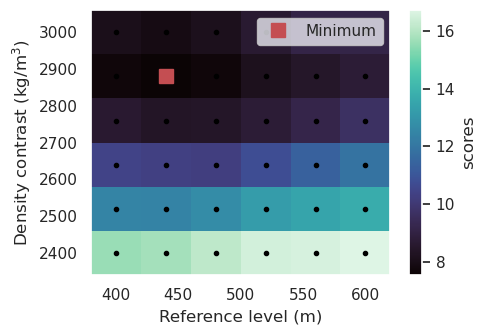

In [34]:
# set kwargs to pass to the inversion
kwargs = {
    "grav_data_column": "observed_grav",
    "deriv_type": "annulus",
    "solver_damping": best_damping,
    # set stopping criteria
    "max_iterations": 200,
    "l2_norm_tolerance": 0.5,
    "delta_l2_norm_tolerance": 1.005,
}

best_inv_results, best_zref, best_density_contrast, _, _, _ = (
    cross_validation.zref_density_optimal_parameter(
        grav_df=grav_df,
        constraints_df=constraint_points,
        zref_values=np.linspace(400, 600, 6),
        density_contrast_values=np.linspace(2400, 3000, 6),
        starting_topography=starting_topography,
        regional_grav_kwargs={
            "regional_method": "dc_shift",
            "constraints_df": constraint_points,
        },
        plot_cv=True,
        results_fname="combining_it_all_zref_density_CV",
        **kwargs,
    )
)

Lets see how the cross-validation perform by comparing the estimated `best` values to the true values as defined by the `true topography`

In [35]:
print(f"True zref value: {true_zref}, best zref from CV: {best_zref}")
print(
    f"True density contrast: {true_density_contrast}, "
    f"best density contrast from CV: {best_density_contrast}"
)

True zref value: 492.2704164812973, best zref from CV: 440.0
True density contrast: 2669, best density contrast from CV: 2880.0


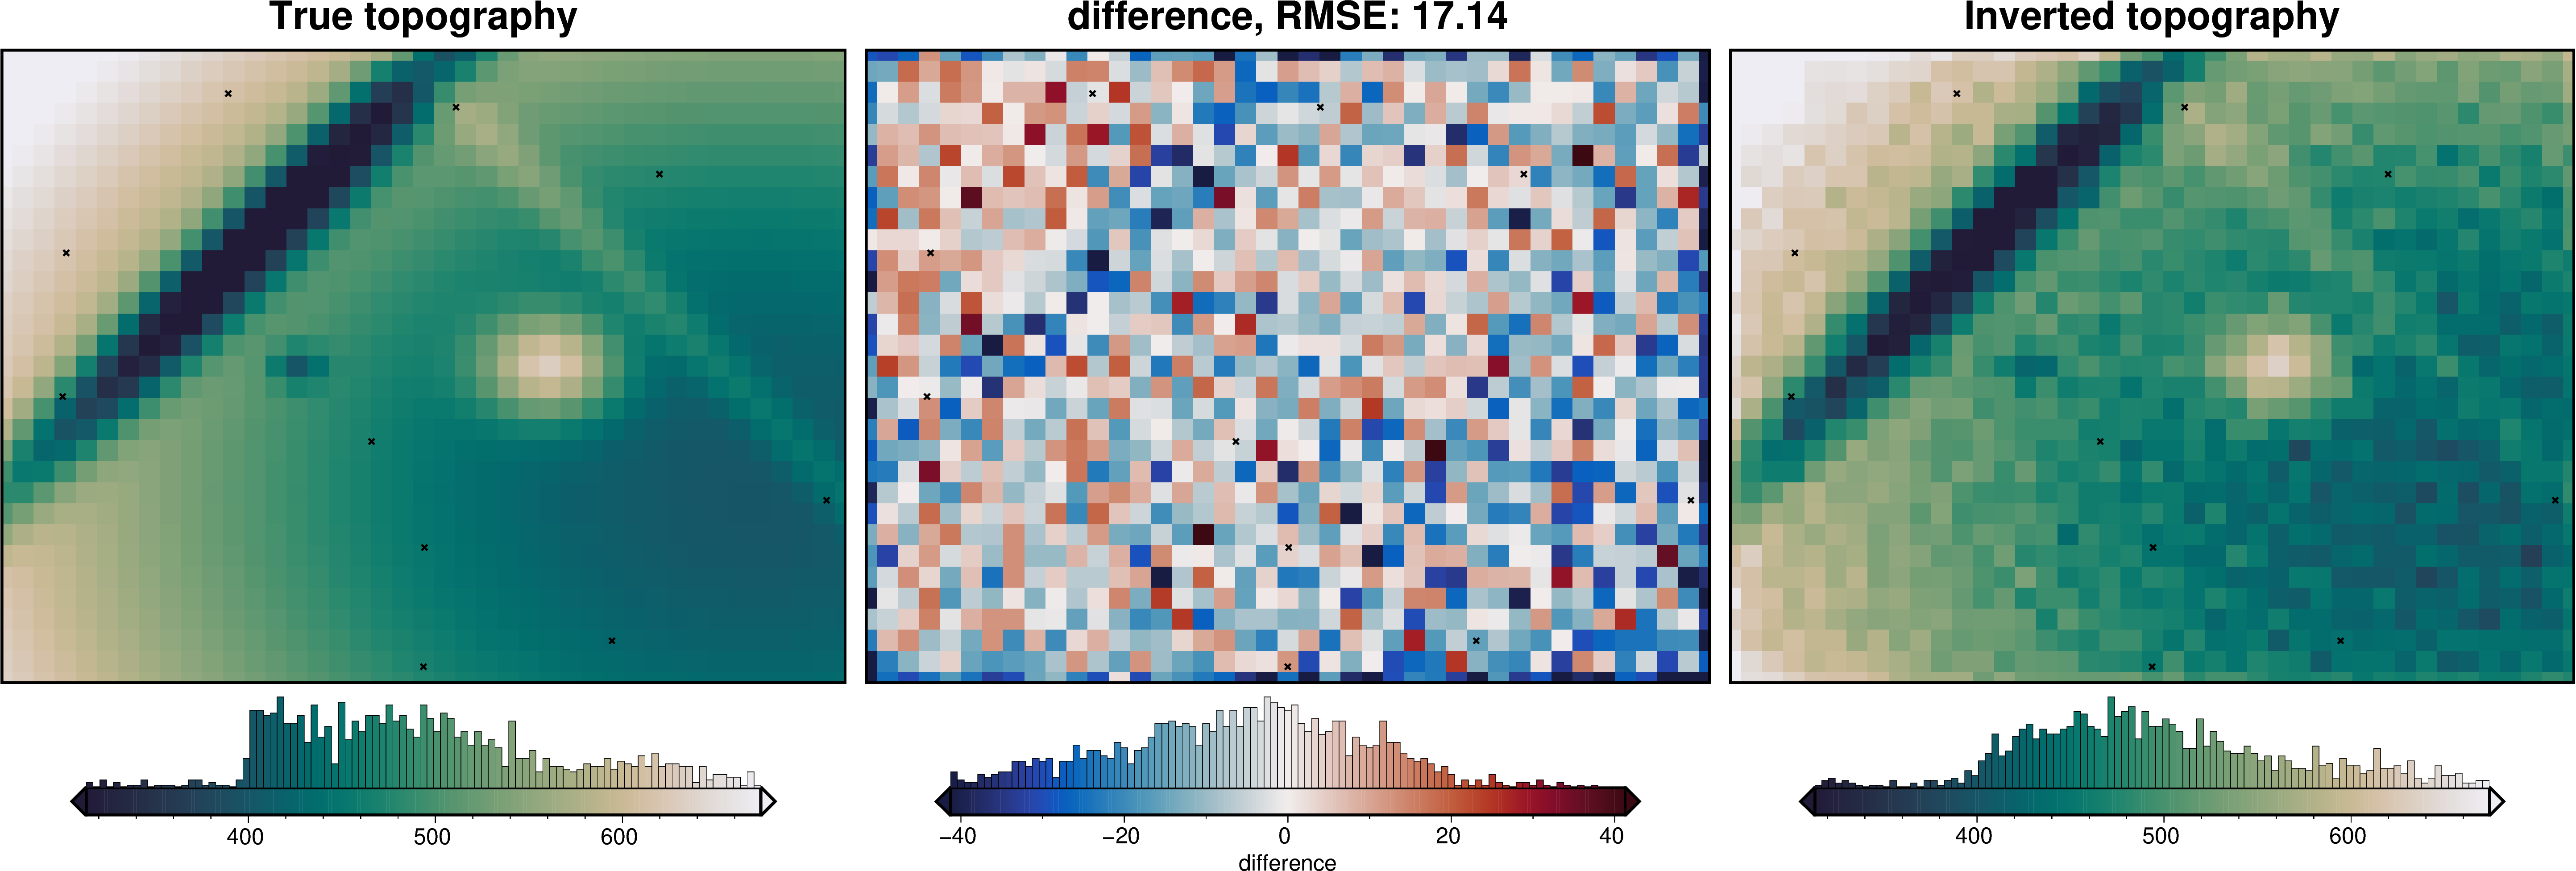

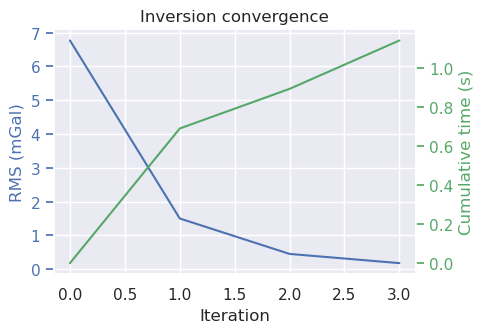

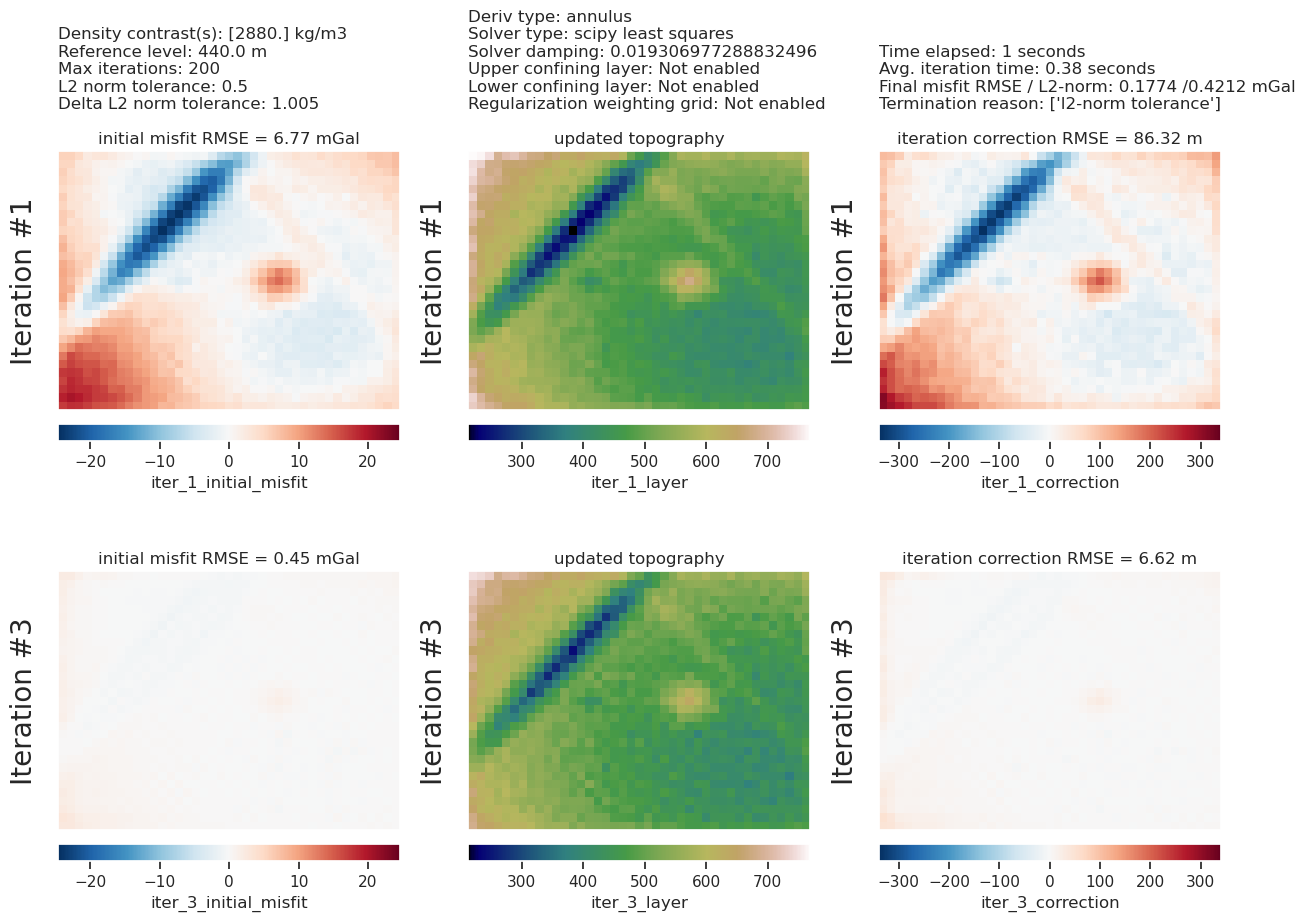

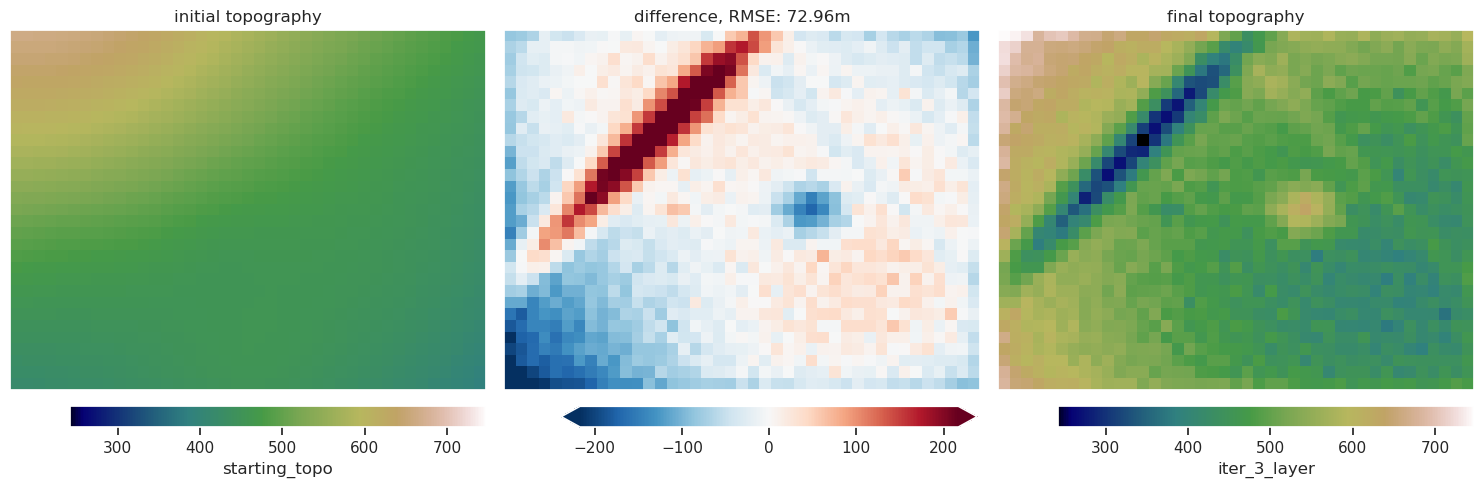

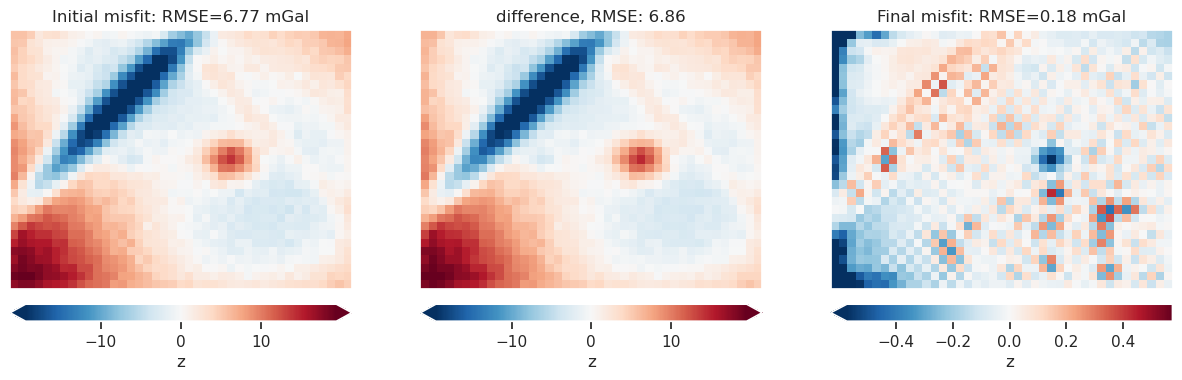

In [36]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = best_inv_results

plotting.plot_convergence(
    grav_results,
    iter_times=parameters["Iteration times"],
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.15c",
)

In [37]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 7.52 m


## 6) Adhering to constraints: weighting grid
To force the invesion to adhere to the starting model we need to supply a weighting grid. At each iteration, the `correction grid` is multiplied by this weighting grid to alter the iteration's correction. Therefore, this weighting grid should be ~0 at the constraints, so that they aren't altered from the starting model. These values should increase to ~1 at a distance to allow the inversion to be un-affected at locations far from constraints. 

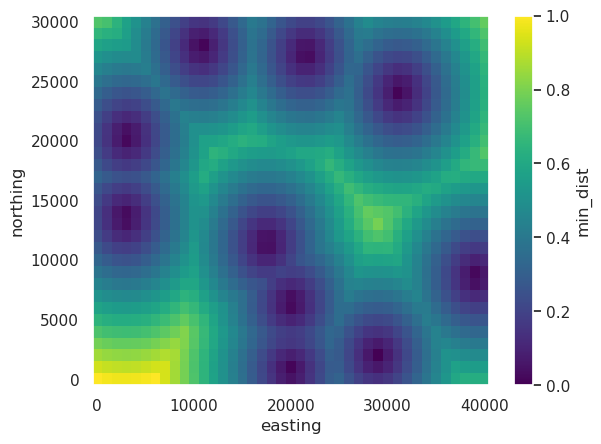

In [38]:
# calculate the distance between each grid cell and the nearest constraint, then
# normalize those values between 0 and 1
weighting_grid = utils.normalized_mindist(
    constraint_points,
    starting_prisms,
    low=0,
    high=1,
)
weighting_grid.plot()

## Perform inversion
Now we can perform the inversion, supplying the argument `apply_weighting_grid=True` and ensuring that the weighting grid is included as the `weights` variable to the argument `prism_layer`. Note that we have increased the `max_iterations` from 30 to 100. This is because the weighting grid reduces the correction values at each iterations, resulting in the need for more iterations.

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

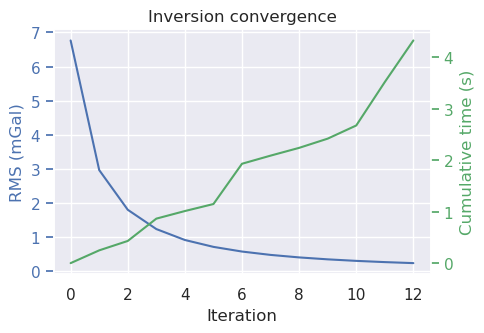

In [40]:
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

kwargs = {
    # needed to create starting topography
    "starting_topography": starting_topography,
    # needed to create starting prisms model
    "starting_prisms_kwargs": {
        "density_contrast": best_density_contrast,
        "zref": best_zref,
    },
    # needed to calculate misfit
    "grav_data_column": "observed_grav",
    # needed to separate regional
    "regional_grav_kwargs": {
        "regional_method": "dc_shift",
        "constraints_df": constraint_points,
    },
    # inversion parameters
    "deriv_type": "annulus",
    "solver_damping": best_damping,
    "max_iterations": 200,
    "l2_norm_tolerance": 0.5,
    "delta_l2_norm_tolerance": 1.005,
    "apply_weighting_grid": True,
    "weighting_grid": weighting_grid,
    "plot_convergence": True,
}

# run the inversion workflow, including re-creating the prism layer with the
# optimal zref and density
results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    create_starting_prisms=True,
    calculate_regional_misfit=True,
    **kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

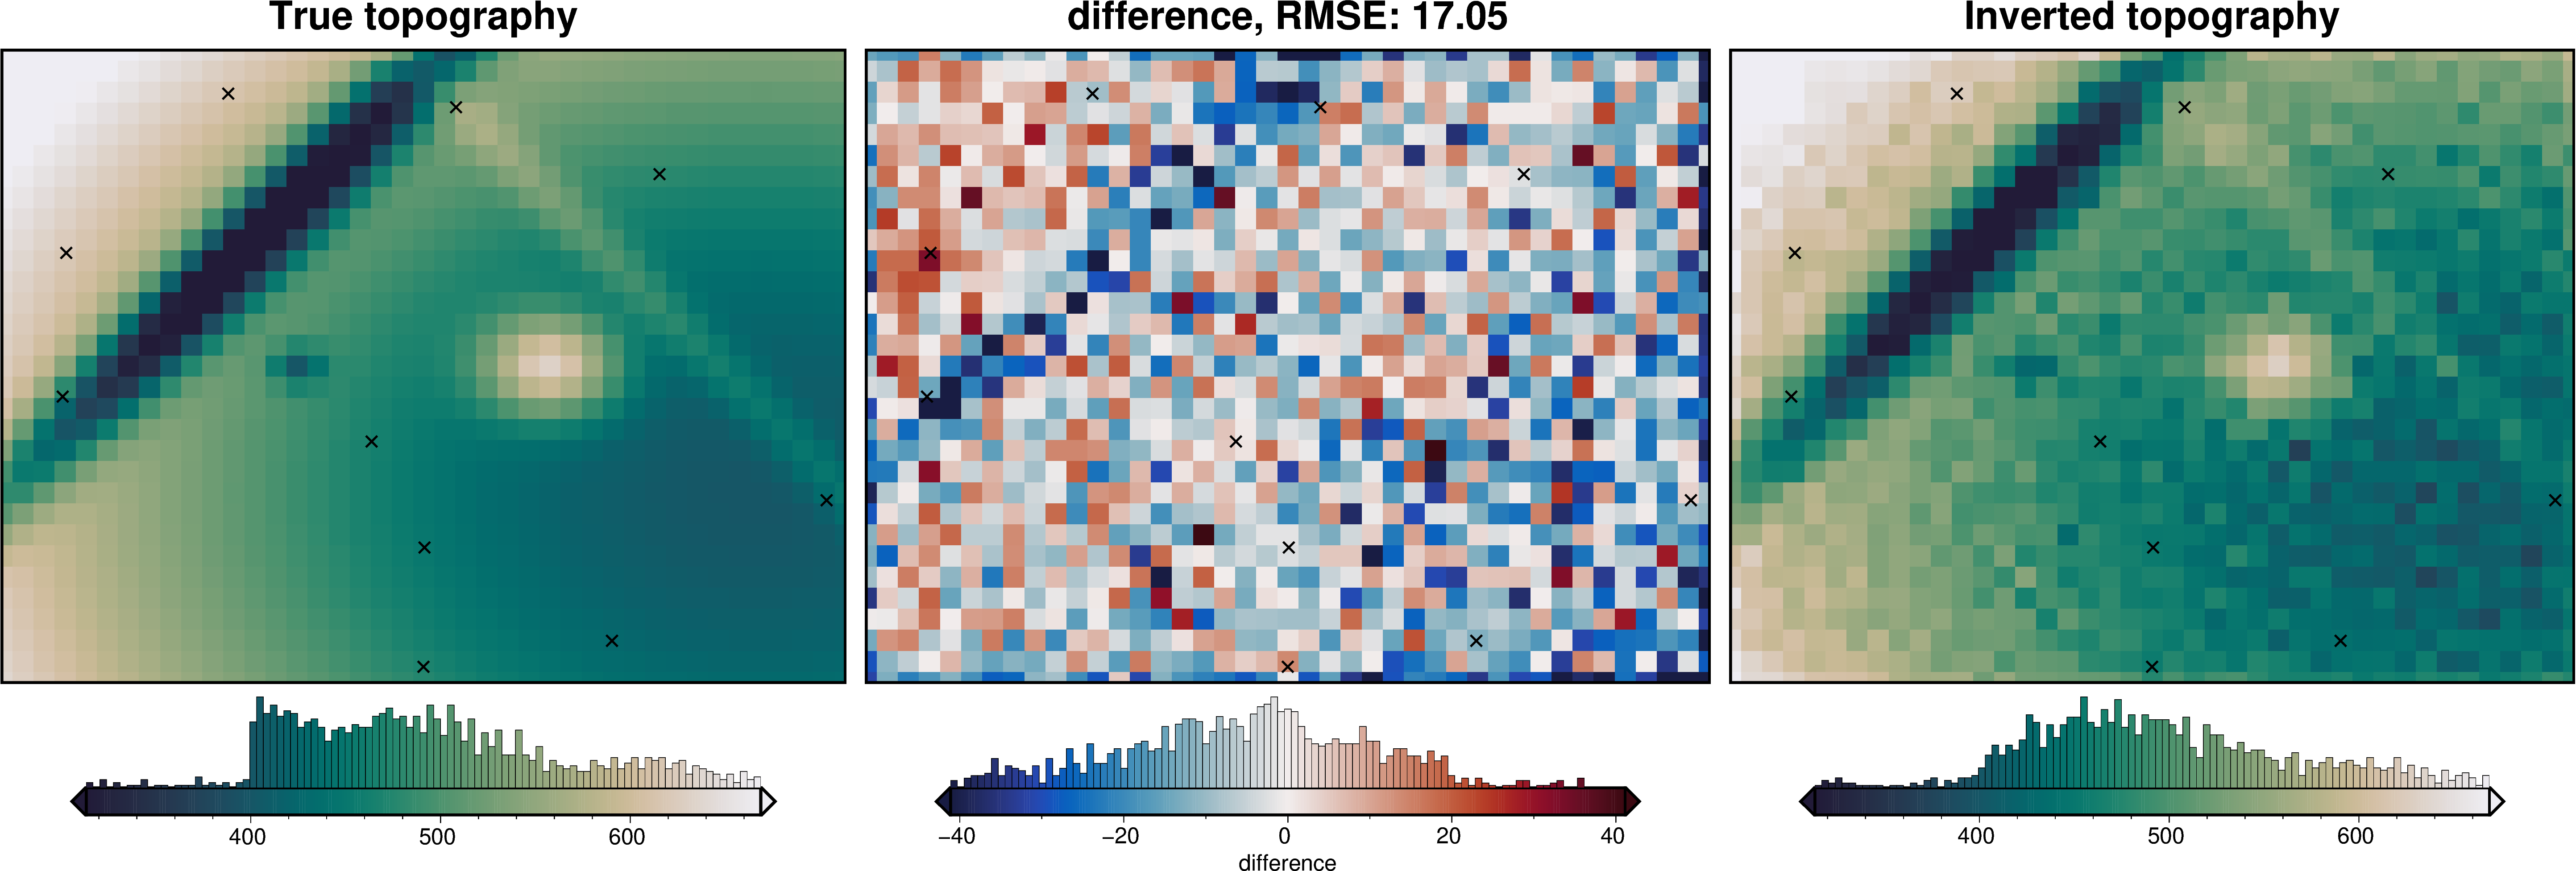

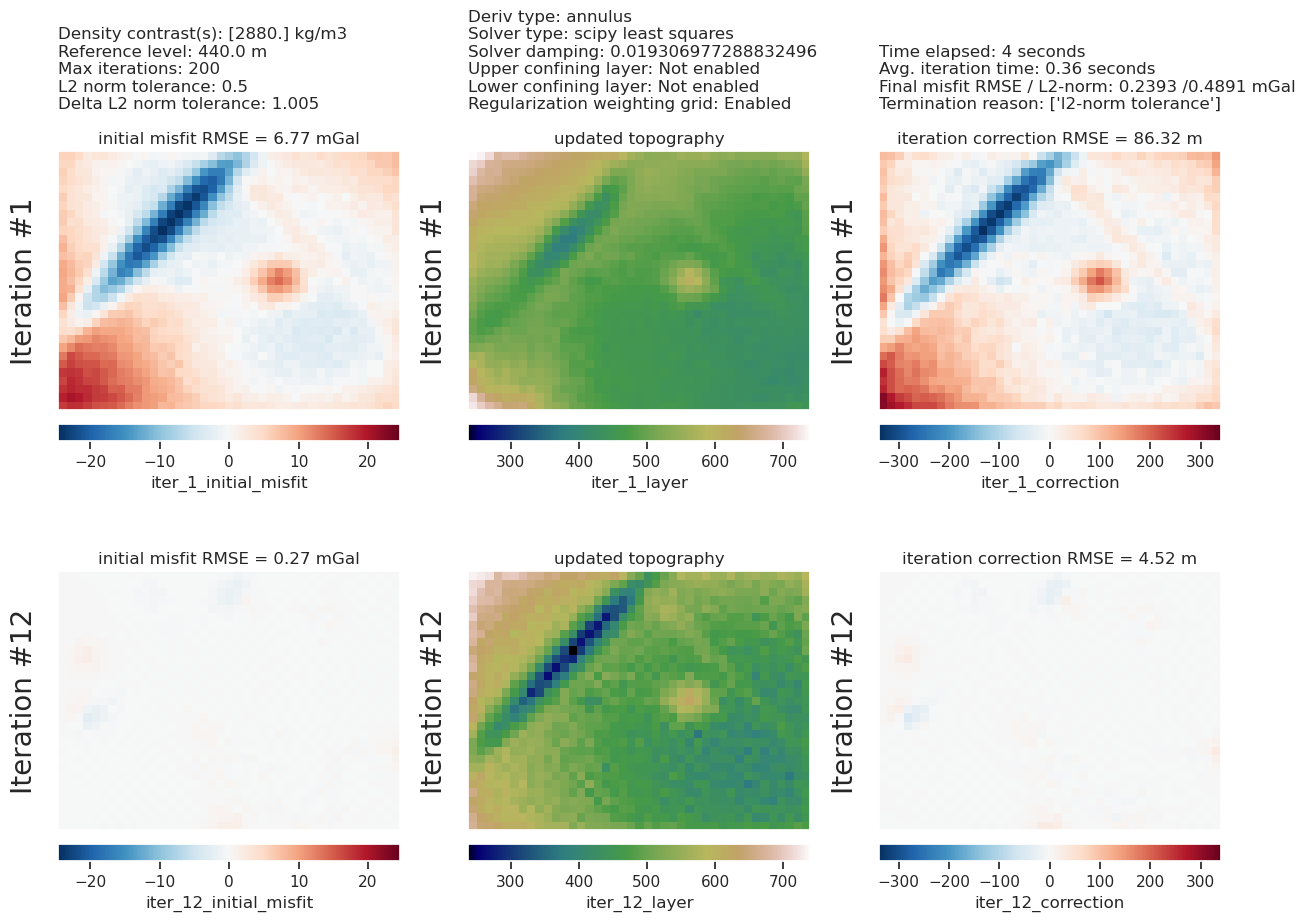

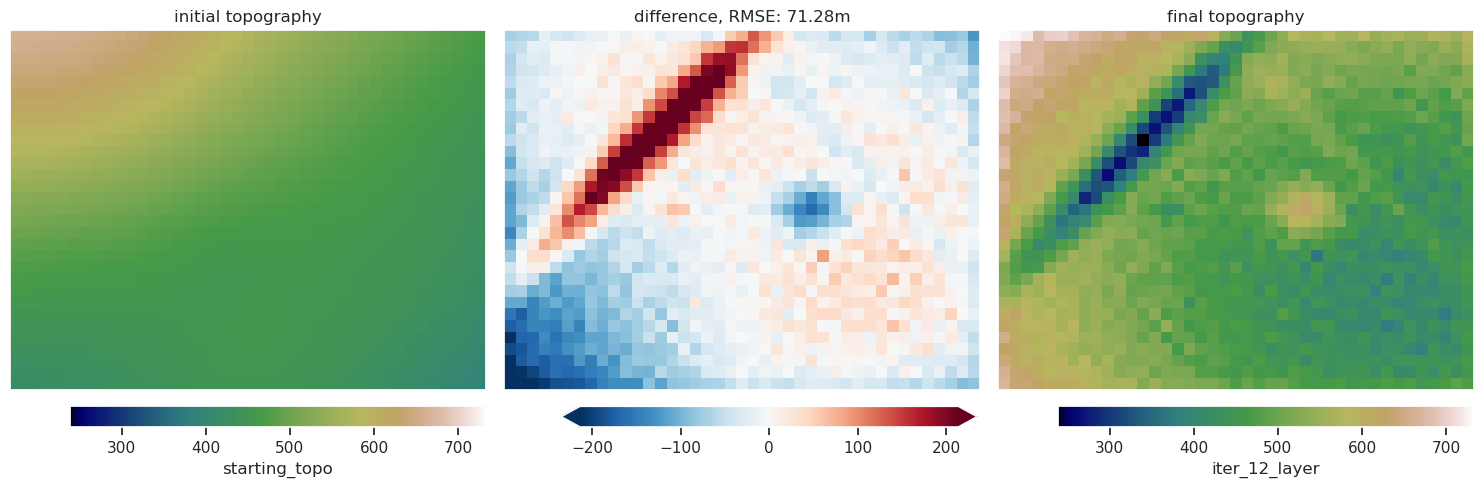

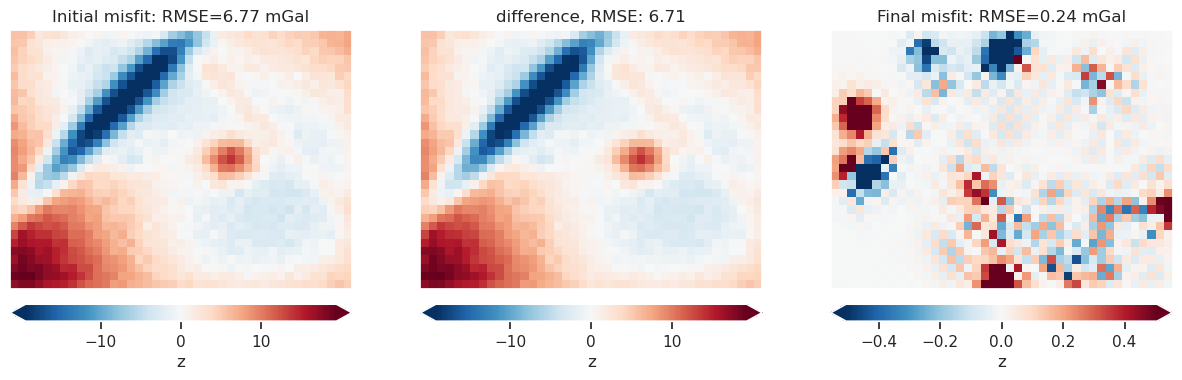

In [41]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
    constraints=constraint_points,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    # diff_lims=(-20, 20),
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

In [42]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 13.91 m


In [43]:
constraint_points

,easting,northing,upward,starting_topography,inverted_topography
0,3052.331575,20376.899884,619.779099,580.163740,590.310923
1,31196.751690,24112.171083,479.563412,481.652035,482.047725
2,17536.369258,11428.233994,465.786893,458.230368,461.199603
3,28938.607113,1978.090407,426.413502,438.512760,438.535165
4,39119.580480,8644.367979,428.773305,425.210470,428.152545
5,21539.834816,27287.805832,546.901160,547.287244,552.364173
6,20044.818546,6401.560607,450.406755,455.069067,450.974430
7,2882.045334,13563.718855,460.979806,499.138482,485.732618
8,10737.559204,27936.180591,614.084318,624.948915,625.274183
9,19995.300033,746.976827,470.409607,452.397262,459.303475


#